# Project: Yelp Business Analysis with PyMongo + Spark
This lab simulates a real-world big data pipeline using **MongoDB**, **PySpark**, and the **Yelp Open Dataset**.
We'll:
- Insert data into MongoDB from JSON
- Load that data into Spark
- Perform analysis
- Save results back to MongoDB


## Insert Yelp Data into MongoDB

In [ ]:
import json
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["yelp"]

# Drop old collections if they exist
db["business"].drop()
db["review"].drop()
db["user"].drop()
db["checkin"].drop()
db["tip"].drop()


# === Trim and load only first 1000 businesses ===
with open("yelp-data/yelp_academic_dataset_business.json", "r", encoding="utf-8") as f:
    business_data = [json.loads(line) for _, line in zip(range(10000), f)]
db["business"].insert_many(business_data)
print(f"✅ Inserted {len(business_data)} businesses")

# === Trim and load only first 5000 reviews ===
with open("yelp-data/yelp_academic_dataset_review.json", "r", encoding="utf-8") as f:
    review_data = [json.loads(line) for _, line in zip(range(50000), f)]
db["review"].insert_many(review_data)
print(f"✅ Inserted {len(review_data)} reviews")

# === Trim and load only first 5000 reviews ===
with open("yelp-data/yelp_academic_dataset_user.json", "r", encoding="utf-8") as f:
    user_data = [json.loads(line) for _, line in zip(range(50000), f)]
db["user"].insert_many(user_data)
print(f"✅ Inserted {len(user_data)} users")

# === Trim and load only first 5000 checkins ===
with open("yelp-data/yelp_academic_dataset_checkin.json", "r", encoding="utf-8") as f:
    checkin_data = [json.loads(line) for _, line in zip(range(50000), f)]
db["checkin"].insert_many(checkin_data)
print(f"✅ Inserted {len(checkin_data)} checkins")

# === Trim and load only first 5000 tips ===
with open("yelp-data/yelp_academic_dataset_tip.json", "r", encoding="utf-8") as f:
    tip_data = [json.loads(line) for _, line in zip(range(50000), f)]
db["tip"].insert_many(tip_data)
print(f"✅ Inserted {len(tip_data)} tips")



✅ Inserted 10000 businesses
✅ Inserted 50000 reviews
✅ Inserted 50000 reviews
✅ Inserted 50000 users
✅ Inserted 50000 users
✅ Inserted 50000 checkins
✅ Inserted 50000 checkins
✅ Inserted 50000 tips
✅ Inserted 50000 tips


## Start Spark Session

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("YelpProject").getOrCreate()

## Load Data from MongoDB via PyMongo

In [3]:
# Read documents, exclude '_id'
business_docs = list(db["business"].find({}, {"_id": 0}))
review_docs = list(db["review"].find({}, {"_id": 0}))
user_docs = list(db["user"].find({}, {"_id": 0}))

# Convert to Spark DataFrames
df_business = spark.createDataFrame(business_docs)
df_review = spark.createDataFrame(review_docs)

df_business.show(3)
df_review.show(3)

# Inspect first few user_docs records for schema issues
for i, doc in enumerate(user_docs[:5]):
    print(f'Record {i}:', doc)

# Optionally: Remove records missing key fields (e.g., 'user_id')
user_docs_clean = [doc for doc in user_docs if 'user_id' in doc]

# Try creating DataFrame again
df_user = spark.createDataFrame(user_docs_clean)
df_user.show(3)


df_user.show(3)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{ByAppointmentOnl...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                NULL|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{BusinessAcceptsC...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{Tuesday -> 8:0-1...|      1| 38.551126|  -90.335695|    

## Top Businesses by City or Category

Use Spark to aggregate ratings & review counts by city/category.

Store results in MongoDB for fast querying (e.g., “Best pizza in Toronto”).

Problem solved: helping users find high-quality businesses in their area.

In [4]:
from pyspark.sql import functions as F

# Aggregate top businesses by city and category using Spark

# Top businesses by city
top_by_city = (
    df_business
    .groupBy("city")
    .agg(
        F.count("business_id").alias("business_count"),
        F.avg("stars").alias("avg_stars"),
        F.sum("review_count").alias("total_reviews")
    )
    .orderBy(F.desc("avg_stars"))
)

top_by_city.show(5)

# Top businesses by category (explode categories first)
df_business_exploded = df_business.withColumn("category", F.explode(F.split("categories", ", ")))
top_by_category = (
    df_business_exploded
    .groupBy("category")
    .agg(
        F.count("business_id").alias("business_count"),
        F.avg("stars").alias("avg_stars"),
        F.sum("review_count").alias("total_reviews")
    )
    .orderBy(F.desc("avg_stars"))
)

top_by_category.show(5)

# Store results in MongoDB
db["top_business_by_city"].drop()
db["top_business_by_category"].drop()

city_results = [row.asDict() for row in top_by_city.collect()]
category_results = [row.asDict() for row in top_by_category.collect()]

db["top_business_by_city"].insert_many(city_results)
db["top_business_by_category"].insert_many(category_results)

print("✅ Aggregated results saved to MongoDB")

+------------------+--------------+---------+-------------+
|              city|business_count|avg_stars|total_reviews|
+------------------+--------------+---------+-------------+
|         Riverside|             1|      5.0|            8|
| Woolwich Township|             1|      5.0|            7|
|Catalina Foothills|             2|      5.0|           61|
|           Fernley|             1|      5.0|            7|
|  Town 'n' Country|             1|      5.0|           67|
+------------------+--------------+---------+-------------+
only showing top 5 rows
+--------------------+--------------+---------+-------------+
|            category|business_count|avg_stars|total_reviews|
+--------------------+--------------+---------+-------------+
|        Estheticians|             1|      5.0|           13|
|      Aerial Fitness|             1|      5.0|            8|
|       Lice Services|             2|      5.0|           11|
|Real Estate Photo...|             4|      5.0|           35|
| 

## Top city or bussiness visualization

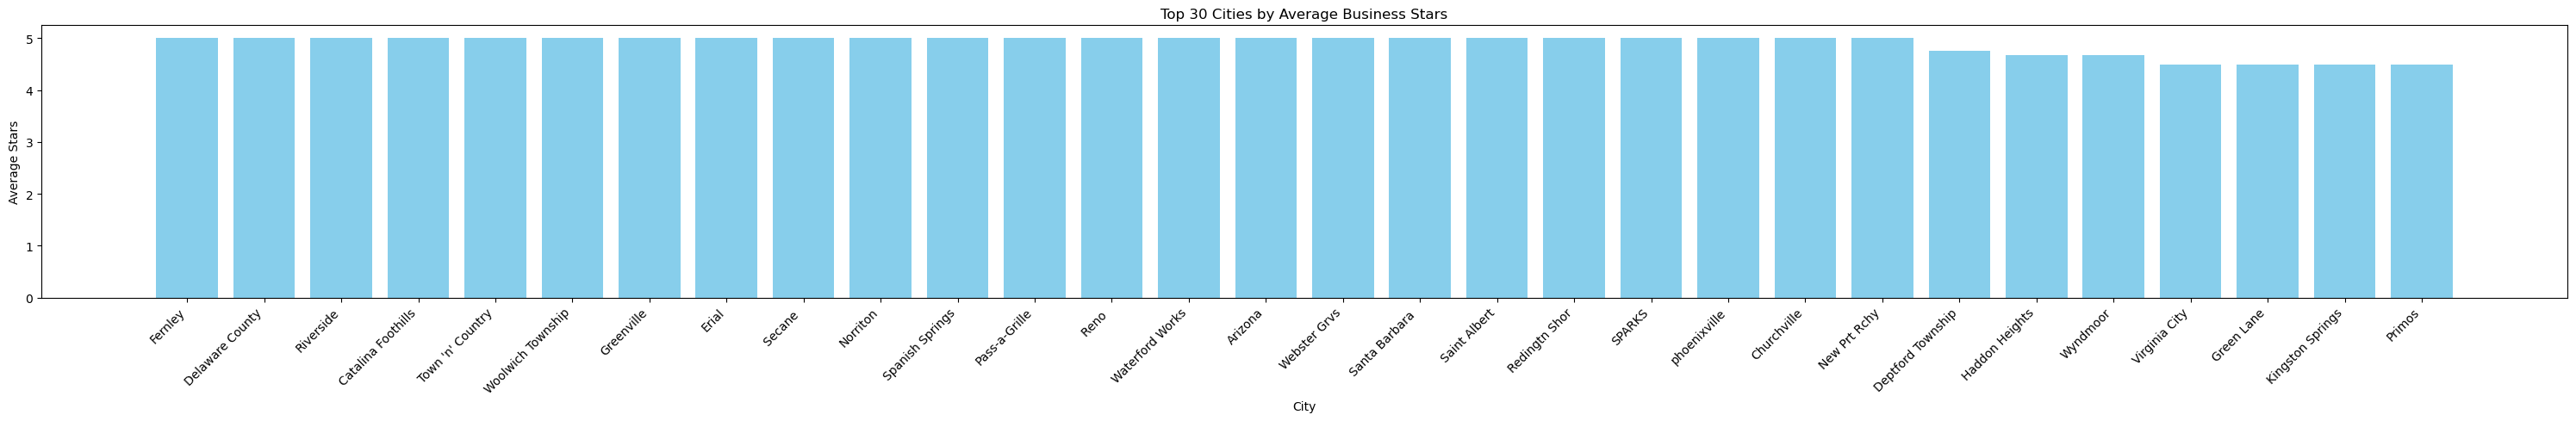

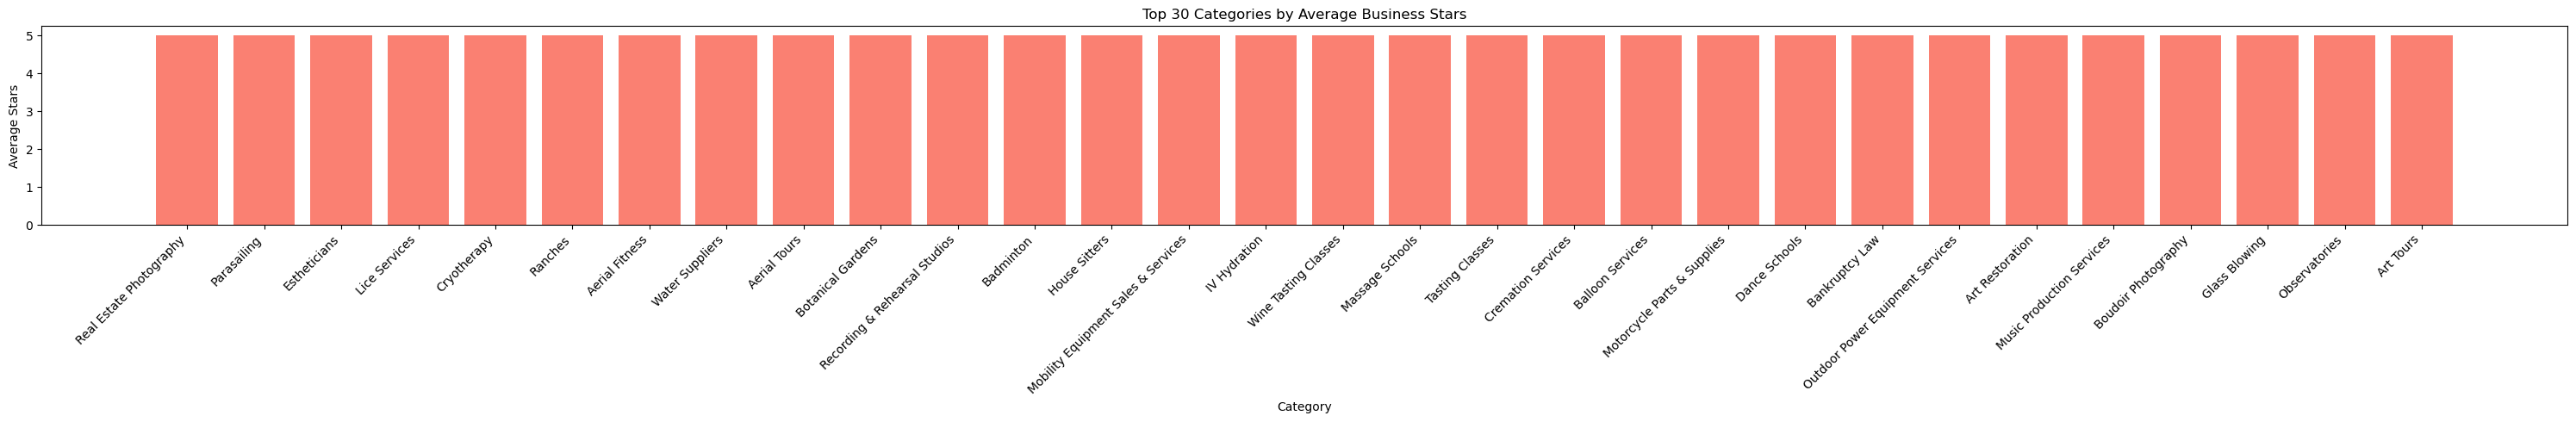

In [5]:
import matplotlib.pyplot as plt

# Top 30 cities by average stars
city_names = [row['city'] for row in city_results[:30]]
city_avg_stars = [row['avg_stars'] for row in city_results[:30]]

plt.figure(figsize=(30, 5))
plt.bar(city_names, city_avg_stars, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 30 Cities by Average Business Stars')
plt.xlabel('City')
plt.ylabel('Average Stars')
plt.tight_layout()
plt.show()

# Top 30 categories by average stars
category_names = [row['category'] for row in category_results[:30]]
category_avg_stars = [row['avg_stars'] for row in category_results[:30]]

plt.figure(figsize=(30, 5))
plt.bar(category_names, category_avg_stars, color='salmon')
plt.xticks(rotation=45, ha='right')
plt.title('Top 30 Categories by Average Business Stars')
plt.xlabel('Category')
plt.ylabel('Average Stars')
plt.tight_layout()
plt.show()

## Bottom city or bussiness visualization

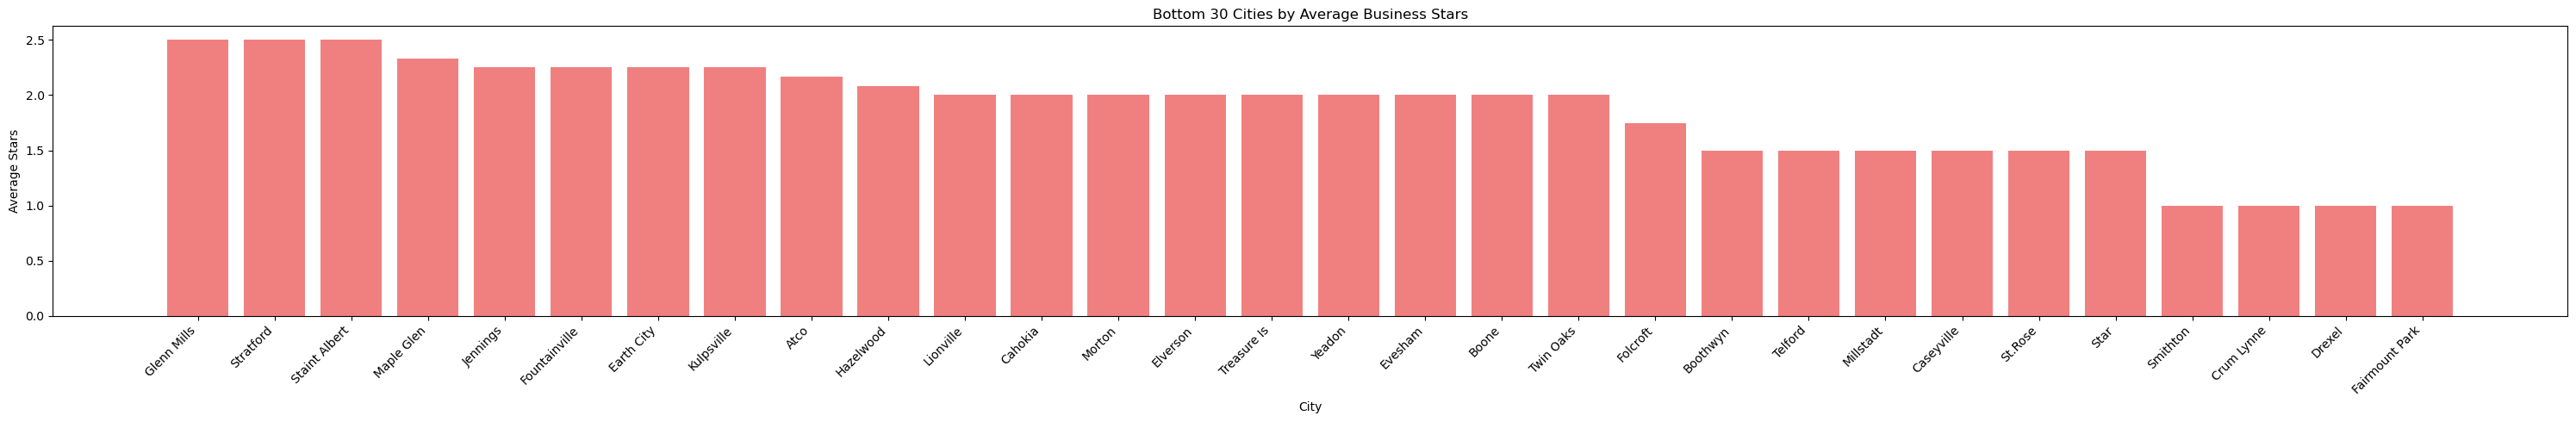

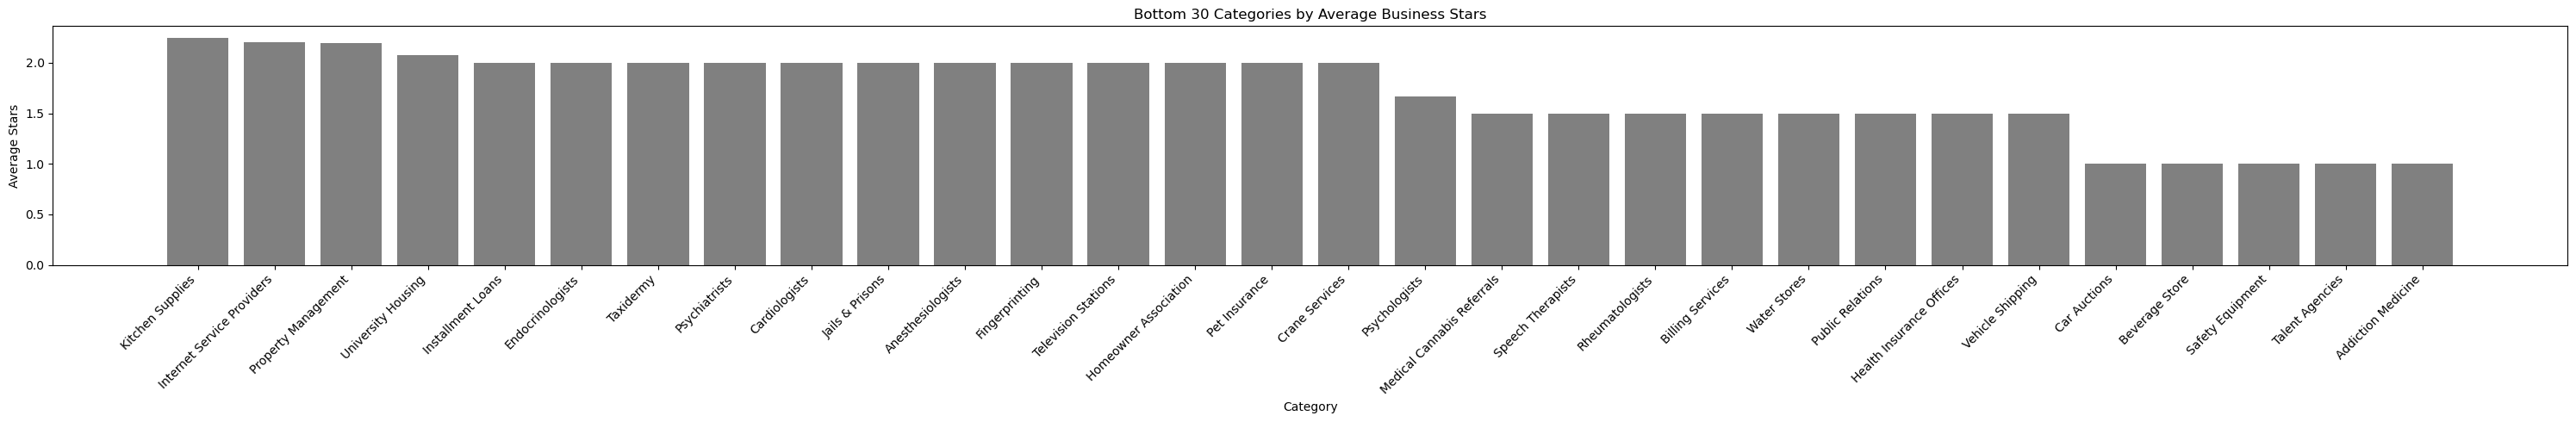

In [6]:
# Bottom 30 cities by average stars
city_names_least = [row['city'] for row in city_results[-30:]]
city_avg_stars_least = [row['avg_stars'] for row in city_results[-30:]]

plt.figure(figsize=(30, 5))
plt.bar(city_names_least, city_avg_stars_least, color='lightcoral')
plt.xticks(rotation=45, ha='right')
plt.title('Bottom 30 Cities by Average Business Stars')
plt.xlabel('City')
plt.ylabel('Average Stars')
plt.tight_layout()
plt.show()

# Bottom 30 categories by average stars
category_names_least = [row['category'] for row in category_results[-30:]]
category_avg_stars_least = [row['avg_stars'] for row in category_results[-30:]]

plt.figure(figsize=(30, 5))
plt.bar(category_names_least, category_avg_stars_least, color='gray')
plt.xticks(rotation=45, ha='right')
plt.title('Bottom 30 Categories by Average Business Stars')
plt.xlabel('Category')
plt.ylabel('Average Stars')
plt.tight_layout()
plt.show()

## Review Trends Over Time

Analyze how ratings for a business change over months/years.

Detect seasonality (e.g., “ice cream shops get more reviews in summer”).

Problem solved: businesses can adapt marketing to time-based demand.

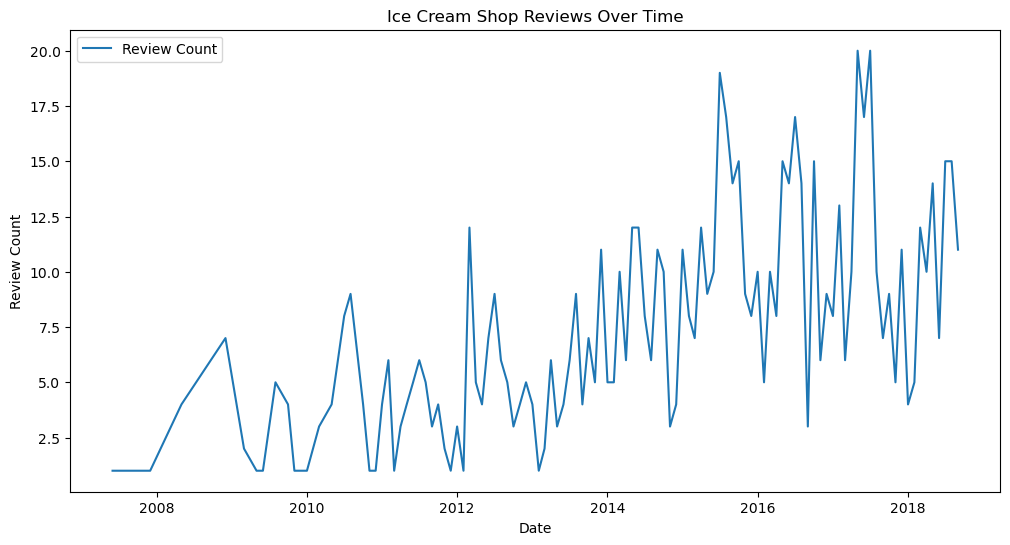

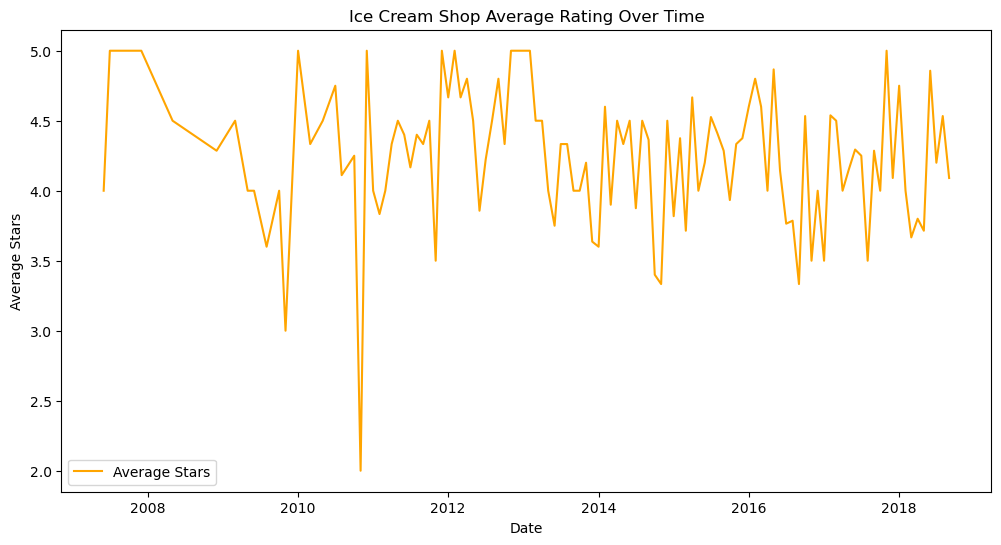

In [7]:
# Example: Analyze review trends for ice cream shops

import pandas as pd
import matplotlib.pyplot as plt

# Get business_ids for ice cream shops from exploded business DataFrame
ice_cream_businesses = df_business_exploded.filter(F.lower(F.col('category')) == 'ice cream & frozen yogurt')
ice_cream_ids = [row['business_id'] for row in ice_cream_businesses.select('business_id').distinct().collect()]

# Filter reviews for those businesses
ice_cream_reviews = df_review.filter(F.col('business_id').isin(ice_cream_ids))
ice_cream_reviews = ice_cream_reviews.withColumn('year', F.year('date')).withColumn('month', F.month('date'))

# Aggregate: monthly review count and average stars
monthly_trends = (
    ice_cream_reviews
    .groupBy('year', 'month')
    .agg(
        F.count('review_id').alias('review_count'),
        F.avg('stars').alias('avg_stars')
    )
    .orderBy('year', 'month')
)

monthly_trends_pd = monthly_trends.toPandas()

# Plot review count and average stars over time
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(monthly_trends_pd[['year', 'month']].assign(day=1)), monthly_trends_pd['review_count'], label='Review Count')
plt.ylabel('Review Count')
plt.xlabel('Date')
plt.title('Ice Cream Shop Reviews Over Time')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(monthly_trends_pd[['year', 'month']].assign(day=1)), monthly_trends_pd['avg_stars'], label='Average Stars', color='orange')
plt.ylabel('Average Stars')
plt.xlabel('Date')
plt.title('Ice Cream Shop Average Rating Over Time')
plt.legend()
plt.show()

## Fake Review Detection

Use Spark MLlib to detect suspicious users (e.g., many reviews in different cities in short time).

Problem solved: identifying potential review fraud.

Number of users for clustering: 1956
+--------------------+-------------+------------+---------+-------+
|             user_id|unique_cities|review_count| features|cluster|
+--------------------+-------------+------------+---------+-------+
|FLRcde8_Gu8UCttSN...|            1|           1|[1.0,1.0]|      0|
|876n8vqmsR0EsIWm4...|            1|           1|[1.0,1.0]|      0|
|aX3vDE1UmbdrWeOsg...|            1|           1|[1.0,1.0]|      0|
|5fyqw5D4Dl5jK-uVe...|            1|           1|[1.0,1.0]|      0|
|3M1_pyDSgMP6sRMz5...|            1|           1|[1.0,1.0]|      0|
|dI63Pz29RfsDEz7yo...|            1|           1|[1.0,1.0]|      0|
|li7W918oKQmLLoJ2_...|            1|           1|[1.0,1.0]|      0|
|IeSz60ozr1yAVIH8C...|            1|           1|[1.0,1.0]|      0|
|UDrnPm0G-XzmcNCOz...|            1|           1|[1.0,1.0]|      0|
|R_JF2hdQOAFsfgA8m...|            1|           1|[1.0,1.0]|      0|
+--------------------+-------------+------------+---------+-------+
only showin

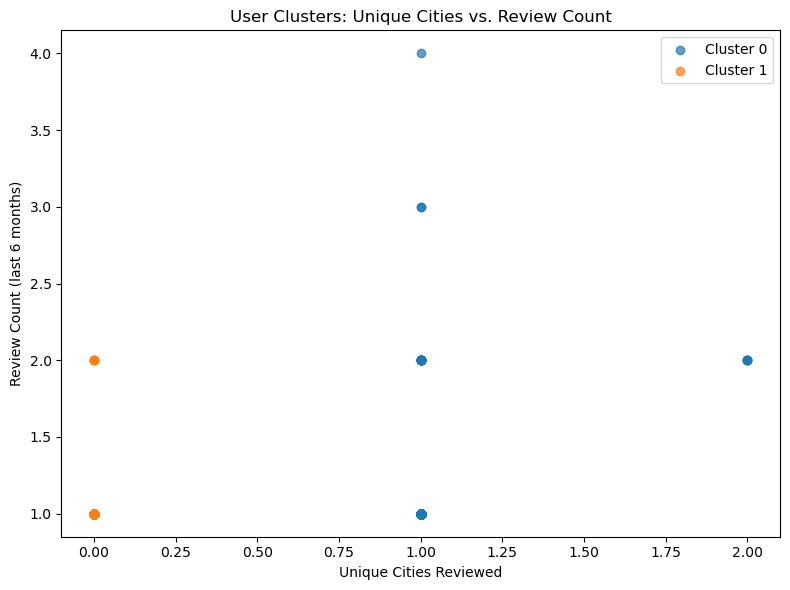

In [8]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
import pandas as pd
import matplotlib.pyplot as plt

# Join reviews with business to get city info for each review
review_with_city = df_review.join(df_business.select("business_id", "city"), on="business_id", how="left")

# Calculate number of unique cities reviewed by each user in the last 6 months
# Use July 1, 2018 as the start date for the 6-month window

start_date = "2018-07-01"
recent_reviews = review_with_city.filter(
    F.col("date") >= F.lit(start_date).cast(DateType())
)
user_city_counts = (
    recent_reviews
    .groupBy("user_id")
    .agg(
        F.countDistinct("city").alias("unique_cities"),
        F.count("review_id").alias("review_count")
    )
)

# Prepare features for clustering
assembler = VectorAssembler(inputCols=["unique_cities", "review_count"], outputCol="features")
user_features = assembler.transform(user_city_counts)

# Remove rows with nulls in features before clustering
user_features_clean = user_features.filter(user_features['features'].isNotNull())

# Check if there are enough rows for clustering
print('Number of users for clustering:', user_features_clean.count())

# Fit KMeans only if there are enough rows
if user_features_clean.count() >= 2:
    kmeans = KMeans(k=2, seed=42, featuresCol="features", predictionCol="cluster")
    model = kmeans.fit(user_features_clean)
    clustered = model.transform(user_features_clean)

    # Show suspicious users (cluster with highest avg unique_cities)
    suspicious_cluster = (
        clustered.groupBy("cluster")
        .agg(F.avg("unique_cities").alias("avg_cities"))
        .orderBy(F.desc("avg_cities"))
        .first()["cluster"]
    )
    suspicious_users = clustered.filter(F.col("cluster") == suspicious_cluster)
    suspicious_users.show(10)
    # Optionally: Save suspicious user_ids to MongoDB
    db["suspicious_users"].drop()
    # Convert DenseVector to list for MongoDB compatibility
    def convert_densevector(row_dict):
        if "features" in row_dict and hasattr(row_dict["features"], "toArray"):
            row_dict["features"] = row_dict["features"].toArray().tolist()
        return row_dict
    suspicious_docs = [convert_densevector(row.asDict()) for row in suspicious_users.collect()]
    db["suspicious_users"].insert_many(suspicious_docs)
    print("✅ Suspicious users detected and saved to MongoDB")
else:
    print('Not enough users for clustering.')

# Convert clustered DataFrame to Pandas for plotting
clustered_pd = clustered.select('unique_cities', 'review_count', 'cluster').toPandas()
plt.figure(figsize=(8, 6))
for cluster_id in clustered_pd['cluster'].unique():
    subset = clustered_pd[clustered_pd['cluster'] == cluster_id]
    plt.scatter(subset['unique_cities'], subset['review_count'], label=f'Cluster {cluster_id}', alpha=0.7)

plt.xlabel('Unique Cities Reviewed')
plt.ylabel('Review Count (last 6 months)')
plt.title('User Clusters: Unique Cities vs. Review Count')
plt.legend()
plt.tight_layout()
plt.show()

## Recommender System

Build a collaborative filtering model with Spark MLlib.

Recommend businesses based on user review history.

Store recommendations in MongoDB for fast access.

Problem solved: improve personalized discovery for users.

In [10]:
from pyspark.ml.recommendation import ALS
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer

# Prepare data for ALS: user_id, business_id, rating (stars)
als_data = df_review.select(
    F.col("user_id"),
    F.col("business_id"),
    F.col("stars").cast("float").alias("rating")
)

# StringIndexer for user_id and business_id (ALS requires integer IDs)

user_indexer = StringIndexer(inputCol="user_id", outputCol="user_idx").fit(als_data)
business_indexer = StringIndexer(inputCol="business_id", outputCol="business_idx").fit(als_data)

als_data_indexed = user_indexer.transform(als_data)
als_data_indexed = business_indexer.transform(als_data_indexed)

# Train ALS model
als = ALS(
    userCol="user_idx",
    itemCol="business_idx",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=10,
    maxIter=10,
    regParam=0.1
)
model = als.fit(als_data_indexed)

# Generate top 5 business recommendations for each user
user_recs = model.recommendForAllUsers(5)

# Map back to original user_id and business_id
user_id_map = als_data_indexed.select("user_id", "user_idx").distinct()
business_id_map = als_data_indexed.select("business_id", "business_idx").distinct()

user_recs_flat = (
    user_recs
    .withColumn("rec", F.explode("recommendations"))
    .select("user_idx", F.col("rec.business_idx").alias("business_idx"), F.col("rec.rating").alias("pred_rating"))
    .join(user_id_map, on="user_idx", how="left")
    .join(business_id_map, on="business_idx", how="left")
    .select("user_id", "business_id", "pred_rating")
)

# Collect recommendations for MongoDB
recs_for_mongo = (
    user_recs_flat
    .groupBy("user_id")
    .agg(F.collect_list(F.struct("business_id", "pred_rating")).alias("recommendations"))
)

# Save to MongoDB
db["user_recommendations"].drop()
mongo_docs = [row.asDict() for row in recs_for_mongo.collect()]
db["user_recommendations"].insert_many(mongo_docs)

# Show 5 example users and their recommendations
for doc in mongo_docs[:5]:
    print(f"User: {doc['user_id']}")
    for rec in doc['recommendations']:
        print(f"  Business: {rec['business_id']}, Predicted Rating: {rec['pred_rating']:.2f}")
    print("-" * 40)
    
print("✅ User recommendations generated and saved to MongoDB")

User: --4AjktZiHowEIBCMd4CZA
  Business: xs8GLIHS_Ec7fLkrTpa4KQ, Predicted Rating: 6.75
  Business: 3uw1vR4E5TCrxEmDW12_Mw, Predicted Rating: 6.73
  Business: S2233x-r73hC5l4s9keI7Q, Predicted Rating: 6.59
  Business: Dt26KHsIfgnS1q52HKgIcw, Predicted Rating: 6.56
  Business: VAy2exJyAWMtA5_X7fMa4g, Predicted Rating: 6.47
----------------------------------------
User: --gafFJlfUIwzifH583ruw
  Business: ErpOHBaOcmZjnBw0EutQJg, Predicted Rating: 5.08
  Business: SjjrTfCxmLp0kJgy62sRAg, Predicted Rating: 4.95
  Business: doDLC83cBMVNLIMhpZWSuQ, Predicted Rating: 4.82
  Business: 1sXN7Oxteo5dP5nwIDyO4w, Predicted Rating: 4.82
  Business: F_EMJrm-ljz4KPJBMPTbpQ, Predicted Rating: 4.80
----------------------------------------
User: --pvE2eu3WWwikKs1E2QDw
  Business: EFOlgTAEXEd876-iGm4_xg, Predicted Rating: 6.83
  Business: -e9MepGs8piOYdwuP5x7tw, Predicted Rating: 6.76
  Business: VX_hsSXeHRYbfUxjxC3Urw, Predicted Rating: 6.76
  Business: GH6ee5Jfd5GexPReNtddgA, Predicted Rating: 6.73
  Bus

## User Segmentation

Cluster users with Spark (e.g., frequent reviewers, one-time reviewers, local explorers).

MongoDB can hold user profiles with cluster labels.

Problem solved: businesses can target promotions more effectively.

In [12]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F

# Prepare features for clustering: review_count, unique_cities
assembler = VectorAssembler(inputCols=["review_count", "unique_cities"], outputCol="features2")
user_features_seg = assembler.transform(user_features_clean)

# Remove rows with nulls in features
user_features_seg_clean = user_features_seg.filter(user_features_seg['features2'].isNotNull())

# Cluster users (e.g., 3 segments: frequent reviewers, one-time reviewers, local explorers)
kmeans_seg = KMeans(k=3, seed=42, featuresCol="features2", predictionCol="segment")
model_seg = kmeans_seg.fit(user_features_seg_clean)
segmented_users = model_seg.transform(user_features_seg_clean)

# Add cluster labels to user profiles
user_profiles = segmented_users.select("user_id", "review_count", "unique_cities", "segment")

# Save to MongoDB
db["user_segments"].drop()
user_profiles_docs = [row.asDict() for row in user_profiles.collect()]
db["user_segments"].insert_many(user_profiles_docs)

print("✅ User segmentation complete and saved to MongoDB")
user_profiles.show(10)

✅ User segmentation complete and saved to MongoDB
+--------------------+------------+-------------+-------+
|             user_id|review_count|unique_cities|segment|
+--------------------+------------+-------------+-------+
|FLRcde8_Gu8UCttSN...|           1|            1|      0|
|876n8vqmsR0EsIWm4...|           1|            1|      0|
|aX3vDE1UmbdrWeOsg...|           1|            1|      0|
|5fyqw5D4Dl5jK-uVe...|           1|            1|      0|
|3M1_pyDSgMP6sRMz5...|           1|            1|      0|
|dI63Pz29RfsDEz7yo...|           1|            1|      0|
|li7W918oKQmLLoJ2_...|           1|            1|      0|
|IeSz60ozr1yAVIH8C...|           1|            1|      0|
|UDrnPm0G-XzmcNCOz...|           1|            1|      0|
|D3TkaW_qYXRW8lh-U...|           1|            0|      1|
+--------------------+------------+-------------+-------+
only showing top 10 rows
+--------------------+------------+-------------+-------+
|             user_id|review_count|unique_cities|segmen

## Evaluate Recommender Performance
Split review data into training and test sets.

Train ALS on the training set and predict ratings on the test set.

Calculate RMSE to measure recommender accuracy.

Show sample predictions for user-business pairs.


In [14]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate ALS recommender performance using RMSE
# Split data into train/test
(training, test) = als_data_indexed.randomSplit([0.8, 0.2], seed=42)

als_eval = ALS(
    userCol="user_idx",
    itemCol="business_idx",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=10,
    maxIter=10,
    regParam=0.1
)
model_eval = als_eval.fit(training)
predictions = model_eval.transform(test)

evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)
print(f"ALS Recommender RMSE on test set: {rmse:.4f}")

# Optionally: Show sample predictions
predictions.select("user_id", "business_id", "rating", "prediction").show(10)

ALS Recommender RMSE on test set: 2.1950
+--------------------+--------------------+------+----------+
|             user_id|         business_id|rating|prediction|
+--------------------+--------------------+------+----------+
|7OUAzKZj6LUrQ3G7g...|S3Kl763P-wKnDLFy0...|   2.0| 1.5647478|
|mcx0aeOgvt4Yul5lr...|u_S84xiDCRJ3CV204...|   4.0|  5.259724|
|-KduD3wwydWDq2GrO...|twNHYgtUkxoeFbLHx...|   3.0|   3.43281|
|XTWdXSOoUJnIMiVSA...|_RwlMTw9uFeOkfX9C...|   1.0| 0.9476099|
|Loe7kgm7UurfezQEM...|6kAXOzE7fqaBZINQV...|   5.0| 1.6637379|
|2N_gW_rtIoVzifhgd...|-ikBycdroyTLDBHR9...|   4.0| 1.5428491|
|xTlqpuuqtO0FWs12g...|71MulAHeKm5p2kIIG...|   4.0| 2.3456192|
|9a3N79voBcU4H9XQ8...|USekrAG0-4tJUs9V2...|   5.0| 2.9185286|
|uBb5_DPYAXPYXvs9u...|tzVLTQNUtiCAxUZmE...|   3.0| 4.0744514|
|n-lBS02-3yvlY5Q91...|2S_CEQYBbp8RO1bJm...|   2.0|  3.708786|
+--------------------+--------------------+------+----------+
only showing top 10 rows
+--------------------+--------------------+------+----------+
|   

## Compare Spark vs. MongoDB Query Performance
Time a Spark query and a MongoDB query for counting users with more than 5 reviews.

Print execution times for both systems to compare speed.


In [15]:
import time

# Example: Compare query execution time for Spark vs. MongoDB

# 1. Spark query: Count users with more than 5 reviews
start_spark = time.time()
spark_count = user_profiles.filter(user_profiles.review_count > 5).count()
end_spark = time.time()
spark_time = end_spark - start_spark
print(f"Spark: Users with >5 reviews = {spark_count}, Execution time: {spark_time:.4f} seconds")

# 2. MongoDB query: Count users with more than 5 reviews
start_mongo = time.time()
mongo_count = db["user_segments"].count_documents({"review_count": {"$gt": 5}})
end_mongo = time.time()
mongo_time = end_mongo - start_mongo
print(f"MongoDB: Users with >5 reviews = {mongo_count}, Execution time: {mongo_time:.4f} seconds")

Spark: Users with >5 reviews = 0, Execution time: 31.7995 seconds
MongoDB: Users with >5 reviews = 0, Execution time: 0.0070 seconds
